# Отбор на кафедру ИППИ Веприков Андрей, задача номер 5

В данной задаче нужно из "идеального" датасета из 10 цифр сгенерировать большее кол-во данных, обучить на полученном датасете модели классификации и проверить их на реальных данных

## Создание датасета



In [144]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import matplotlib.cbook as cbook
from scipy import ndimage
from sklearn import utils

In [145]:
# Датасет в Colaboratory нужно загружать из своего гугл диска
from google.colab import drive
drive.mount('/gdrive' )

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [146]:
PATH = u'/gdrive/My Drive/data/numbers'

In [147]:
# функция которая преобразует картинку из rgb в один цвет
def rgb2gray(rgb): 
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2] 
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b 
    return gray

In [148]:
#Загрузим 10 "идеальных" фотографий
data_ideal = []
for filename in sorted(os.listdir(PATH)):
    with cbook.get_sample_data(os.path.join(PATH, filename)) as image_file:
        image = plt.imread(image_file)

    data_ideal.append(rgb2gray(image))

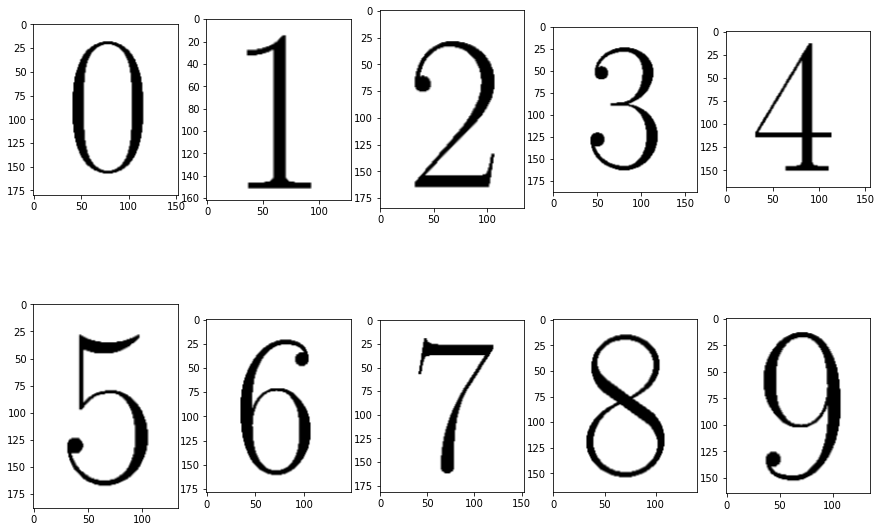

In [149]:
#Вот как они выглядят
fig, ax = plt.subplots(2, 5, figsize = (15, 10))
for i in range(5):
  ax[0][i].imshow(data_ideal[i], 'gray')
  ax[1][i].imshow(data_ideal[5+i], 'gray')

Пока будем работать толкьо с картинкой 1, для остальных 9 картинок применим аналогичные преобразовния. Я буду применять 4 различных независимых преобразовния: Понижение качества, сглаживание, добавление шума и поворот картинки.

In [150]:
one = data_ideal[1]

### Понижение качества

Text(0.5, 1.0, '128x128')

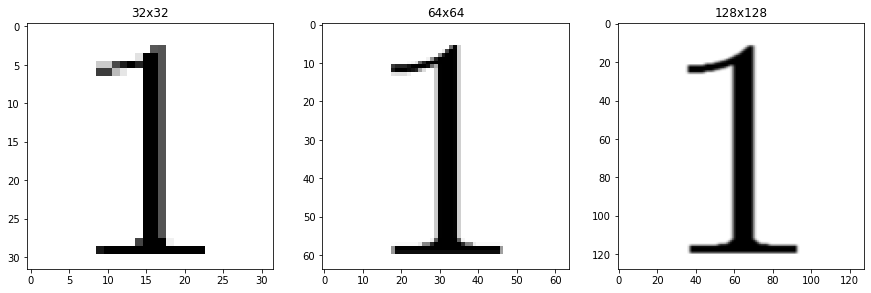

In [151]:
#Понизим разрешение наших картинок, изменив размер
one_32 = cv2.resize(one, (32, 32))
one_64 = cv2.resize(one, (64, 64))
one_128 = cv2.resize(one, (128, 128))

#Покажем, что у нас получилось
fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].imshow(one_32, 'gray')
ax[1].imshow(one_64, 'gray')
ax[2].imshow(one_128, 'gray')
ax[0].set_title("32x32")
ax[1].set_title("64x64")
ax[2].set_title("128x128")

### Слгаживание с использовнием свёртки

Text(0.5, 1.0, '128x128')

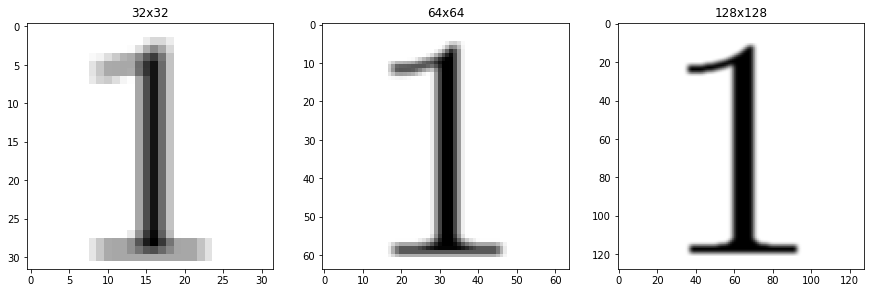

In [152]:
#Проведём свёртку наших изображений
kernel = np.array([[1,1,1],[1,1,1],[1,1,1]],np.float32) / 9

one_32_dst = cv2.filter2D(one_32,-1,kernel)
one_64_dst = cv2.filter2D(one_64,-1,kernel)
one_128_dst = cv2.filter2D(one_128,-1,kernel)

#Покажем, что у нас получилось
fig, ax = plt.subplots(1, 3, figsize = (15, 8))

ax[0].imshow(one_32_dst, 'gray')
ax[1].imshow(one_64_dst, 'gray')
ax[2].imshow(one_128_dst, 'gray')
ax[0].set_title("32x32")
ax[1].set_title("64x64")
ax[2].set_title("128x128")

Как мы видим, для изображения 128x128 ничего практически не поменялось, поэтому не будем включать его сглаженое изображение в наши данные

In [153]:
#Массив из наших 5 картинок
ones = [one_32,
        one_32_dst, 
        one_64, 
        one_64_dst, 
        one_128]

### Добавление шума

Добавим 4 вида шума:

* Гауссовкий - Распределенный по Гауссу аддитивный шум

* Пуассоновский - Пуассон-распределенный шум, генерируемый из данных

* Соль и перец - Заменяет случайные пиксели на белые или чёрные

* Пятна - Мультипликативный шум с использованием out = image + n*image, где
n - равномерный шум с заданными средним и дисперсией

In [154]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col= image.shape
    mean = 0 #среднее
    var = 0.01 #дисперсия
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

  if noise_typ == "s&p":
    row,col = image.shape
    s_vs_p = 0.2 #соотношение белых и черных пикселей, которые будут вставленны
    amount = 0.1 #отношение шума ко всей картинке
    noisy = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    noisy[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    noisy[coords] = 0
    return noisy

  if noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(abs(image * vals)) / float(vals)
    return noisy
    
  if noise_typ =="speckle":
    row,col = image.shape
    gauss = np.random.randn(row,col)
    gauss = gauss.reshape(row,col)        
    noisy = image + image * gauss
    return noisy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


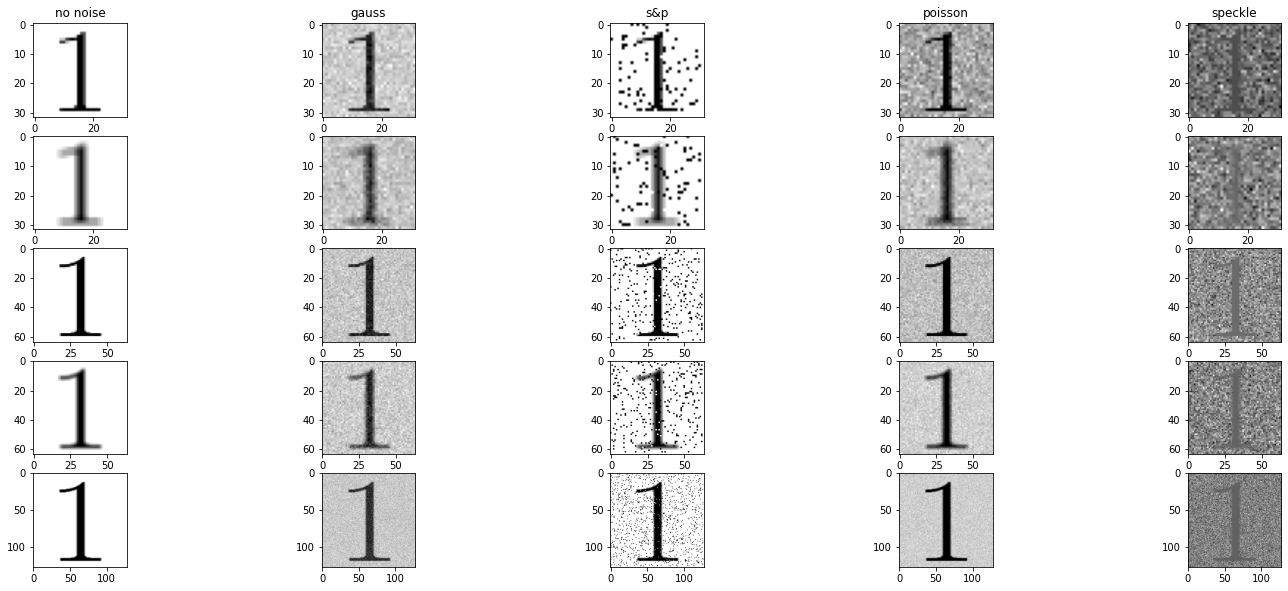

In [155]:
#Покажем, как "зашумится наша картинка"
fig, ax = plt.subplots(len(ones), 5, figsize = (25, 10))

for i in range(len(ones)):
  ax[i][0].imshow(ones[i], 'gray')
  ax[i][1].imshow(noisy('gauss', ones[i]), 'gray')
  ax[i][2].imshow(noisy('s&p', ones[i]), 'gray')
  ax[i][3].imshow(noisy('poisson', ones[i]), 'gray')
  ax[i][4].imshow(noisy('speckle', ones[i]), 'gray')

ax[0][0].set_title("no noise")
ax[0][1].set_title("gauss")
ax[0][2].set_title("s&p")
ax[0][3].set_title("poisson")
ax[0][4].set_title("speckle")

plt.show()

Как мы видим, для изображений размера 32x32 я перестарался с шумом speckle, пожалуй не будем включать их в наши данные

### Поворот изображения

Будем поворачивать все наши картинки на 22.5 и 45 градусов в разные стороны:

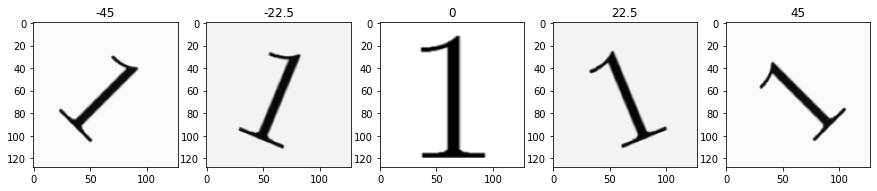

In [156]:
fig, ax = plt.subplots(1, 5, figsize = (15, 8))
i = 0

for angle in [-45, -22.5, 0, 22.5, 45]:
  rotated = ndimage.rotate(ones[4], angle=angle, mode='nearest')
  rotated = cv2.resize(rotated, (ones[4].shape))

  ax[i].imshow(rotated, 'gray')
  ax[i].set_title(str(angle))
  i+=1

Впринципе это все наши преобразования, соединим их все вместе

In [157]:
ones_big = []
for i in range(len(ones)):
  for angle in [-45, -22.5, 0, 22.5, 45]:
    rotated = ndimage.rotate(ones[i], angle=angle, mode='nearest')
    rotated = cv2.resize(rotated, (ones[i].shape))
    ones_big.append(rotated)
    for mode in ["gauss", "s&p", "poisson", "speckle"]:
      if (i > 2) or (mode != "speckle"):
        ones_big.append(noisy(mode, rotated))

print("Размер нашего массива из единиц: ", len(ones_big))

Размер нашего массива из единиц:  110


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


У нас получилось 110 изображений единицы, если мы будем применять такие же преобразования для остальных цифр, то у нас будет датасет из 1100 изображений, что уже приемлимо для обучения моделей

### Преобразование всего датасета

In [158]:
data = []
for num in data_ideal:
  #понижение качества и сглаживание
  kernel = np.array([[1,1,1],[1,1,1],[1,1,1]],np.float32) / 9

  nums = [cv2.resize(num, (32, 32)),
          cv2.filter2D(cv2.resize(num, (32, 32)),-1,kernel),
          cv2.resize(num, (64, 64)),
          cv2.filter2D(cv2.resize(num, (64, 64)),-1,kernel),
          cv2.resize(num, (128, 128))]
  
  for i in range(len(nums)):
    for angle in [-45, -22.5, 0, 22.5, 45]:
      rotated = ndimage.rotate(nums[i], angle=angle, mode='nearest')
      rotated = cv2.resize(rotated, (nums[i].shape))
      data.append(rotated)
      for mode in ["gauss", "s&p", "poisson", "speckle"]:
        if (i > 2) or (mode != "speckle"):
          data.append(noisy(mode, rotated))

print("Размер датасета: ", len(data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Размер датасета:  1100


In [159]:
#Созданим массив целевых переменных:
labels = []
for i in range(10):
  labels += [i] * (len(data) // 10)

In [160]:
#Перемешаем наши данные
data, labels = utils.shuffle(data, labels)
print(labels[:10])

[9, 4, 3, 1, 2, 3, 4, 7, 2, 4]


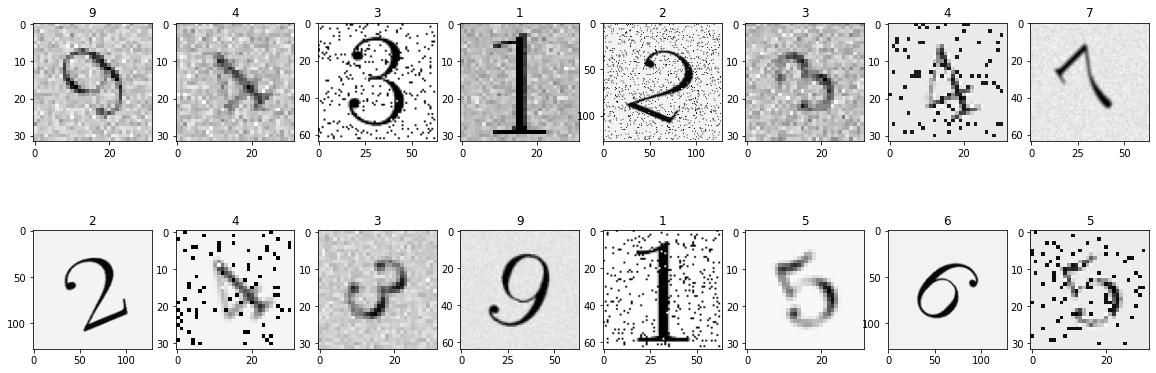

In [161]:
#Посмторим на первые 16 фотографий из нашего датасета
fig, ax = plt.subplots(2, 8, figsize = (20, 7))
for i in range(8):
  ax[0][i].imshow(data[i], 'gray')
  ax[1][i].imshow(data[8+i], 'gray')
  ax[0][i].set_title(str(labels[i]))
  ax[1][i].set_title(str(labels[8+i]))

## GAN

GAN - это архитектура нейронной сети, которая может помочь сгенерировать данные из исходного датасета. Вкратце она работает так: 1 нейронная сеть (генератор) генерирует изображение, а 2 нейроная сеть (дискриминатор) пытается понять, что за изображение перед ней - сгенерированное или из датасета, тем самым 1 нейросеть должна увеличивать функцию ошибки у 2, создавая максимально похожие изображения на изображения из датасета

In [162]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [163]:
#Приведём изображения к одному размеру и нужному типу
data_ideal_1 = data_ideal
for i in range(len(data_ideal_1)):
  data_ideal_1[i] = cv2.resize(data_ideal_1[i], (28, 28))

data_ideal_1 = np.array(data_ideal_1)
data_ideal_1.shape

(10, 28, 28)

In [164]:
#Создание самой архитектуры как класса
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, data, batch_size=128, sample_interval=50):

        # Load the dataset
        X_train = data

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1

0 [D loss: 0.584531, acc.: 84.38%] [G loss: 0.645939]
500 [D loss: 0.685211, acc.: 50.00%] [G loss: 0.703770]
1000 [D loss: 0.682617, acc.: 50.00%] [G loss: 0.711258]
CPU times: user 2min 47s, sys: 5.44 s, total: 2min 52s
Wall time: 2min 16s


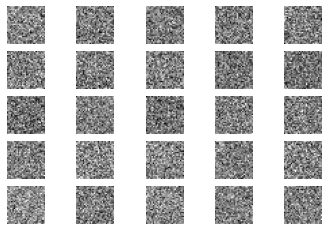

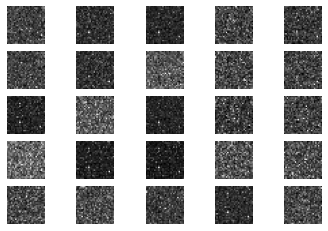

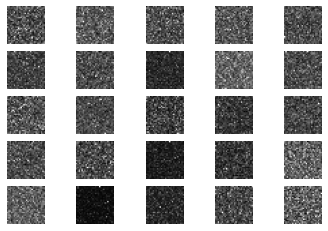

In [165]:
%%time
gan = GAN()
gan.train(epochs=1001, data = data_ideal_1, batch_size=64, sample_interval=500)

Как мы видим, GAN работает очень долго и плохо на моем датасете, мне кажется это происходит из-за того, что в исходном датасете очень мало данных.
Поэтому я дальше никак не буду использовать то, что сгенерировала GAN, а останавлюсь на том, что я сделал до этого.

## Обучение моделей

In [175]:
#Приведём изображения к одному размеру и нужному типу
data_np = data
for i in range(len(data_np)):
  data_np[i] = cv2.resize(data_np[i], (128, 128))

data_np = np.array(data_np)
labels = np.array(labels)
data_np = np.reshape(data_np, [data_np.shape[0], data_np.shape[1] * data_np.shape[2]])

print(data_np.shape)

(1100, 16384)


In [167]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn import ensemble

Линейный классификатор

In [176]:
ridge_classifier = linear_model.RidgeClassifier()

accuracy = cross_val_score(ridge_classifier, X = data_np, y = labels, 
                      scoring = 'accuracy', cv = 3).mean()

print('Качество: ', accuracy.mean())

Качество:  0.921817225274589


Случайный лес

In [177]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state = 1)

accuracy = cross_val_score(rf_classifier, X = data_np, y = labels, 
                      scoring = 'accuracy', cv = 3).mean()

print('Качество: ', accuracy.mean())

Качество:  0.9781817820858336


Качество моделей получилось очень хорошим(как по мне даже слишком хорошим), протестируем наши модели на реальных данных

## Датасет Mnist

Датасет mnist содержит 60000 изображений рукописных цифр размера 28x28, проверим наши модели на этих данных

In [170]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [171]:
#Загрузим датасет mnist
(X, labels_mnist), _ = tf.keras.datasets.mnist.load_data()

print("Размер данных: ", X.shape)
print("Размер целевой переменной:", labels_mnist.shape)

Размер данных:  (60000, 28, 28)
Размер целевой переменной: (60000,)


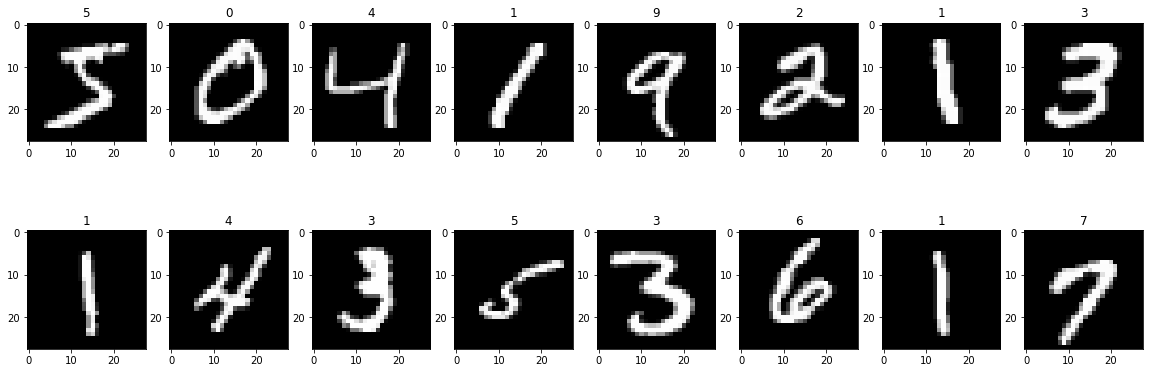

In [172]:
#Покажим первые 16 изображений из нашего датасета
fig, ax = plt.subplots(2, 8, figsize = (20, 7))
for i in range(8):
  ax[0][i].imshow(X[i], 'gray')
  ax[1][i].imshow(X[8+i], 'gray')
  ax[0][i].set_title(str(labels_mnist[i]))
  ax[1][i].set_title(str(labels_mnist[8+i]))

In [178]:
#Преобразуем фотографии к размеру 128x128, на котором обучались наши модели
data_mnist = []
for i in range(X.shape[0]):
  data_mnist.append(cv2.resize(255 - X[i], (128, 128))) #В mnist белые цифры на черном фоне, а мы обучались на черных фотографиях на белом фоне

data_mnist = np.array(data_mnist)
data_mnist = np.reshape(data_mnist, [data_mnist.shape[0], data_mnist.shape[1] * data_mnist.shape[2]])

print(data_mnist.shape)

(60000, 16384)


Линейный классификатор



In [179]:
ridge_classifier.fit(data_np, labels)
predicted = ridge_classifier.predict(data_mnist)
print("Качество:", accuracy_score(labels_mnist, predicted))

Качество: 0.2105


Случайный лес

In [180]:
rf_classifier.fit(data_np, labels)
predicted = rf_classifier.predict(data_mnist)
print("Качество:", accuracy_score(labels_mnist, predicted))

Качество: 0.09561666666666667


Как мы видим, качество моделей очень плохое, это связано с тем, что данные в mnist рукописные, а у нас, как бы я ни старался, все-таки печатные буквы.